In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer1/CervicalCancer/val/images/image_5.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/images/image_1.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/images/image_6.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/images/image_3.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/images/image_4.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/images/image_0.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/images/image_2.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/masks/mask_2.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/masks/mask_3.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/masks/mask_1.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/masks/mask_6.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/masks/mask_4.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/masks/mask_5.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/val/masks/mask_0.bmp
/kaggle/input/cervical-cancer1/CervicalCancer/te

In [3]:
# Basic data manipulations
import pandas as pd
import numpy as np

# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder


# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns


import albumentations as A
from albumentations.pytorch import ToTensorV2
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp


In [4]:
# read img and mask
train_img_paths = sorted(glob('/kaggle/input/cervical-cancer1/CervicalCancer/train/images/*.bmp'))
train_mask_paths = sorted(glob('/kaggle/input/cervical-cancer1/CervicalCancer/train/masks/*.bmp'))
train_df = pd.DataFrame({"images":train_img_paths,"masks":train_mask_paths})
train_df.head()

,images,masks
0,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
1,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
2,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
3,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
4,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...


In [5]:
# read img and mask
val_img_paths = sorted(glob('/kaggle/input/cervical-cancer1/CervicalCancer/val/images/*.bmp'))
val_mask_paths = sorted(glob('/kaggle/input/cervical-cancer1/CervicalCancer/val/masks/*.bmp'))
val_df = pd.DataFrame({"images":val_img_paths,"masks":val_mask_paths})
val_df.head()

,images,masks
0,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
1,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
2,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
3,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
4,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...


In [6]:
# read img and mask
test_img_paths = sorted(glob('/kaggle/input/cervical-cancer1/CervicalCancer/test/images/*.bmp'))
test_mask_paths = sorted(glob('/kaggle/input/cervical-cancer1/CervicalCancer/test/masks/*.bmp'))
test_df = pd.DataFrame({"images":test_img_paths,"masks":test_mask_paths})
test_df.head()

,images,masks
0,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
1,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
2,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...
3,/kaggle/input/cervical-cancer1/CervicalCancer/...,/kaggle/input/cervical-cancer1/CervicalCancer/...


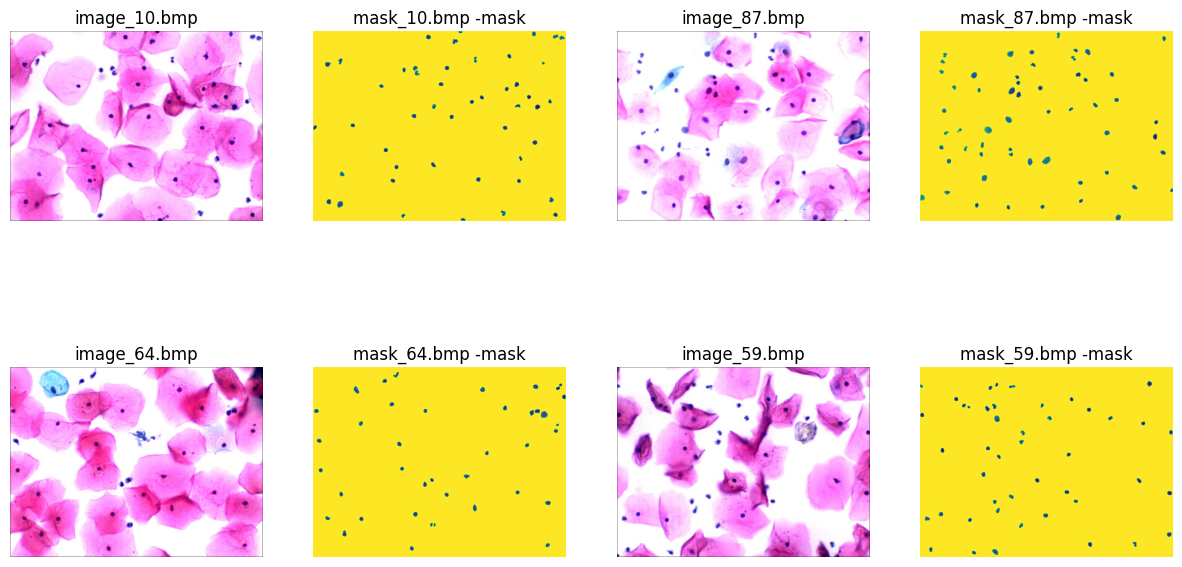

In [7]:
show_imgs = 4
idx = np.random.choice(len(train_df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = train_df.loc[idx[new_i]]['images']
        basename = os.path.basename(full_path)
    else:
        full_path = train_df.loc[idx[new_i]]['masks']
        basename = os.path.basename(full_path) + ' -mask'
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

In [8]:
train_transforms = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
    # A.Normalize(p=1.0),
    # ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(512, 512),
    # ToTensorV2(),
])

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img = img/255
        # img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        #target = torch.tensor(mask, dtype=torch.long)
        # Convert target (mask) to tensor and resize it first
        target = torch.tensor(mask, dtype=torch.float)  # Convert to tensor, shape: [1, 512, 512]

        # Resize the target tensor before creating the sample dictionary
        #target_resized = target.view(3, self.resize[0], self.resize[1])

        # Now create the sample dictionary with the resized target
        sample = {'x': img, 'y': target}

        #sample = {'x': img, 'y': target}
        return sample


In [9]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, val_transforms)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')

len train: 93
len val: 7


In [10]:

import torch
import torch.nn as nn

try:
    from inplace_abn import InPlaceABN
except ImportError:
    InPlaceABN = None


class Conv2dReLU(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
        use_batchnorm=True,
    ):
        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()

        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)

        else:
            bn = nn.Identity()

        super(Conv2dReLU, self).__init__(conv, bn, relu)

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)

    def forward(self, x):
        batch_size, channels, h, w = x.size()

        # Compute average and max across the spatial dimensions separately
        avg_out = torch.mean(x, dim=[2, 3])
        max_out, _ = torch.max(torch.max(x, dim=2)[0], dim=2)  # First max over height, then over width

        # Apply the fully connected layers to the attention mechanism
        out = F.relu(self.fc1(avg_out) + self.fc1(max_out))
        out = torch.sigmoid(self.fc2(out)).view(batch_size, channels, 1, 1)
        return x * out

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = torch.sigmoid(self.conv1(x_cat))
        return x * out

class GatedAxialAttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        groups=8
        kernel_size=7
        stride=1
        bias=True
        # Ensure that in_channels is divisible by groups
        if in_channels % groups != 0:
            raise ValueError(f"in_channels ({in_channels}) must be divisible by groups ({groups})")

        # Calculate out_channels for channel attention based on reduction
        reduced_channels = in_channels // reduction

        super().__init__()

        # Channel-wise attention (cSE)
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_channels, 1),  # reduce channels for channel attention
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1),  # restore channels back to in_channels
            nn.Sigmoid(),
        )

        # Spatial-wise attention (sSE) with variable kernel size
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=kernel_size, padding=kernel_size // 2),  # kernel_size is now adjustable
            nn.Sigmoid()
        )

        # Axial attention components with same input/output channels
        self.q_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, groups=groups)
        self.k_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, groups=groups)
        self.v_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, groups=groups)

        # Gating mechanism
        self.gate = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.size()

        # Channel-wise attention (cSE)
        channel_att = self.cSE(x)  # Shape: [B, C, 1, 1]
        x_c = x * channel_att  # Apply channel-wise attention

        # Spatial-wise attention (sSE)
        spatial_att = self.sSE(x)  # Shape: [B, 1, H, W]
        x_s = x * spatial_att  # Apply spatial-wise attention

        # Axial attention mechanism
        q = self.q_conv(x)  # Query [B, C, H, W]
        k = self.k_conv(x)  # Key [B, C, H, W]
        v = self.v_conv(x)  # Value [B, C, H, W]

        # Reshape and compute attention map
        q_flat = q.view(B, -1, H * W)  # Flatten spatial dimensions
        k_flat = k.view(B, -1, H * W)  # Flatten spatial dimensions
        v_flat = v.view(B, -1, H * W)  # Flatten spatial dimensions

        attn_map = torch.bmm(q_flat.transpose(1, 2), k_flat)  # Dot-product attention
        attn_map = torch.softmax(attn_map, dim=-1)  # Apply softmax

        out = torch.bmm(v_flat, attn_map.transpose(1, 2))  # Apply attention to value
        out = out.view(B, C, H, W)  # Reshape back to original dimensions

        # Gating mechanism
        gate = self.gate(x)  # Shape: [B, C, H, W]
        gated_out = out * gate  # Gated axial attention output

        # Combine both channel and spatial attention with gated axial attention output
        return x_c + x_s + gated_out

class LEQCA_Block(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(LEQCA_Block, self).__init__()
        self.in_channels = in_channels
        self.reduction = reduction

        # Global Average Pooling to get the channel-wise global feature
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # First fully connected layer for latent entropy approximation
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)

        # Second fully connected layer to calculate the attention values
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)

        # Sigmoid to get the attention values between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_channels, h, w = x.size()

        # Step 1: Global Average Pooling
        avg_out = self.global_pool(x)  # Shape: [batch_size, num_channels, 1, 1]

        # Step 2: First fully connected layer with latent entropy
        latent_entropy = F.relu(self.fc1(avg_out))  # Shape: [batch_size, num_channels // reduction, 1, 1]

        # Step 3: Second fully connected layer to get channel weights
        attention_weights = self.fc2(latent_entropy)  # Shape: [batch_size, num_channels, 1, 1]

        # Step 4: Apply sigmoid to the attention weights
        attention_weights = self.sigmoid(attention_weights)

        # Step 5: Multiply input features by attention weights (element-wise)
        out = x * attention_weights.expand_as(x)

        return out


class ComprehensiveAttention(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(ComprehensiveAttention, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class SCSEModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)



class ArgMax(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Clamp(nn.Module):
    def __init__(self, min=0, max=1):
        super().__init__()
        self.min, self.max = min, max

    def forward(self, x):
        return torch.clamp(x, self.min, self.max)


class Activation(nn.Module):
    def __init__(self, name, **params):
        super().__init__()

        if name is None or name == "identity":
            self.activation = nn.Identity(**params)
        elif name == "sigmoid":
            self.activation = nn.Sigmoid()
        elif name == "softmax2d":
            self.activation = nn.Softmax(dim=1, **params)
        elif name == "softmax":
            self.activation = nn.Softmax(**params)
        elif name == "logsoftmax":
            self.activation = nn.LogSoftmax(**params)
        elif name == "tanh":
            self.activation = nn.Tanh()
        elif name == "argmax":
            self.activation = ArgMax(**params)
        elif name == "argmax2d":
            self.activation = ArgMax(dim=1, **params)
        elif name == "clamp":
            self.activation = Clamp(**params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError(
                f"Activation should be callable/sigmoid/softmax/logsoftmax/tanh/"
                f"argmax/argmax2d/clamp/None; got {name}"
            )

    def forward(self, x):
        return self.activation(x)


class Attention(nn.Module):
    def __init__(self, name, in_channels=None, out_channels=None, **params):
        super().__init__()

        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule(**params)
        elif name == "comattn":
            self.attention = ComprehensiveAttention(**params)
        elif name == "sa":
            self.attention = SpatialAttention(**params)
        elif name == "ca":
            self.attention = ChannelAttention(**params)
        elif name == "leqca":
            self.attention = LEQCA_Block(**params)
        elif name == "gaa":
            # Explicitly pass in_channels and out_channels
            if in_channels is None or out_channels is None:
                raise ValueError("in_channels and out_channels must be specified for axial attention")
            # Assuming in_channels = 160
            # Change reduction to 10 or change groups to a compatible value
            # Assuming in_channels = 100
            self.attention = GatedAxialAttentionBlock(**params)

        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)


In [11]:
import torch.nn as nn
#####from .modules import Activation


class SegmentationHead(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, activation=None, upsampling=1
    ):
        conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2
        )
        upsampling = (
            nn.UpsamplingBilinear2d(scale_factor=upsampling)
            if upsampling > 1
            else nn.Identity()
        )
        activation = Activation(activation)
        super().__init__(conv2d, upsampling, activation)


class ClassificationHead(nn.Sequential):
    def __init__(
        self, in_channels, classes, pooling="avg", dropout=0.2, activation=None
    ):
        if pooling not in ("max", "avg"):
            raise ValueError(
                "Pooling should be one of ('max', 'avg'), got {}.".format(pooling)
            )
        pool = nn.AdaptiveAvgPool2d(1) if pooling == "avg" else nn.AdaptiveMaxPool2d(1)
        flatten = nn.Flatten()
        dropout = nn.Dropout(p=dropout, inplace=True) if dropout else nn.Identity()
        linear = nn.Linear(in_channels, classes, bias=True)
        activation = Activation(activation)
        super().__init__(pool, flatten, dropout, linear, activation)

In [12]:
import torch
from segmentation_models_pytorch.base import initialization as init
#####from . import initialization as init
#####from .hub_mixin import SMPHubMixin
from segmentation_models_pytorch.base.hub_mixin import SMPHubMixin

class SegmentationModel(torch.nn.Module, SMPHubMixin):
    def initialize(self):
        init.initialize_decoder(self.decoder)
        init.initialize_head(self.segmentation_head)
        if self.classification_head is not None:
            init.initialize_head(self.classification_head)

    def check_input_shape(self, x):
        h, w = x.shape[-2:]
        output_stride = self.encoder.output_stride
        if h % output_stride != 0 or w % output_stride != 0:
            new_h = (
                (h // output_stride + 1) * output_stride
                if h % output_stride != 0
                else h
            )
            new_w = (
                (w // output_stride + 1) * output_stride
                if w % output_stride != 0
                else w
            )
            raise RuntimeError(
                f"Wrong input shape height={h}, width={w}. Expected image height and width "
                f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w})."
            )

    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""

        self.check_input_shape(x)

        features = self.encoder(x)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels

        return masks

    @torch.no_grad()
    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)` with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        x = self.forward(x)

        return x

In [13]:

import torch
import torch.nn as nn
import torch.nn.functional as F

#####from segmentation_models_pytorch.base import modules as md

class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = Attention(
            attention_type, in_channels=in_channels + skip_channels
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(
                head_channels, head_channels, use_batchnorm=use_batchnorm
            )
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):
        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [14]:
!pip install pytorch-wavelets
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.6 MB/s eta 0:00:00


In [15]:
import torch
import torch.nn.functional as F
from pytorch_wavelets import DTCWTForward, DTCWTInverse

def Wavelet_Transform(image):
    # Ensure image and wavelet transform are on the same device
    device = image.device
    
    # Initialize DTCWT forward transform
    xfm = DTCWTForward(J=1, mode='symmetric').to(device)
    
    # Perform DTCWT decomposition
    Yl, Yh = xfm(image)
    
    # Upsample Yl to match the input shape
    Yl_upsampled = F.interpolate(Yl, size=(image.shape[2], image.shape[3]), mode='bilinear', align_corners=False)
    
    return Yl_upsampled

In [16]:
import torch
import torch.nn as nn
import numpy as np
import functools
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from pretrainedmodels.models.inceptionv4 import InceptionV4, pretrained_settings


class SAA_Block(nn.Module):
    """Selective Attention Aggregation Block."""
    def __init__(self, in_channels, reduction=16):
        super(SAA_Block, self).__init__()
        self.in_channels = in_channels
        self.reduction = reduction

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        pooled = self.global_pool(x)
        attention = self.fc1(pooled)
        attention = F.relu(attention)
        attention = self.fc2(attention)
        attention = self.sigmoid(attention)
        return x * attention.expand_as(x)

class MAA_Block(nn.Module):
    """Memory Augmented Attention Block."""
    def __init__(self, in_channels, memory_slots=16, reduction=16):
        super(MAA_Block, self).__init__()
        self.in_channels = in_channels
        self.memory_slots = memory_slots
        self.reduction = reduction

        self.memory = nn.Parameter(torch.randn(memory_slots, in_channels))
        self.query = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)
        self.key = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.value = nn.Linear(in_channels, in_channels, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_flat = x.view(batch_size, channels, -1)

        query = self.query(x).view(batch_size, channels // self.reduction, -1)
        key = self.key(self.memory).permute(1, 0).unsqueeze(0).expand(batch_size, -1, -1)
        value = self.value(self.memory).unsqueeze(0).expand(batch_size, -1, -1)

        attention_weights = torch.bmm(query.permute(0, 2, 1), key)
        attention_weights = self.softmax(attention_weights)

        attention_output = torch.bmm(attention_weights, value)
        attention_output = attention_output.permute(0, 2, 1).view(batch_size, channels, height, width)
        return attention_output + x



# Combined Ensemble Attention Block (MAA+SAA)
class EnsembleAttention(nn.Module):
    def __init__(self, in_channels):
        super(EnsembleAttention, self).__init__()
        self.saa_block = SAA_Block(in_channels)
        self.maa_block = MAA_Block(in_channels)

    def forward(self, x):
        saa_out = self.saa_block(x)
        maa_out = self.maa_block(x)
        ensemble_out = (saa_out + maa_out) / 2  # Averaging outputs
        return ensemble_out



# Encoder Mixin
class EncoderMixin:
    _output_stride = 32

    @property
    def out_channels(self):
        return self._out_channels[:self._depth + 1]

    @property
    def output_stride(self):
        return min(self._output_stride, 2 ** self._depth)

    def set_in_channels(self, in_channels, pretrained=True):
        if in_channels == 3:
            return
        self._in_channels = in_channels
        if self._out_channels[0] == 3:
            self._out_channels = tuple([in_channels] + list(self._out_channels)[1:])
        patch_first_conv(self, new_in_channels=in_channels, pretrained=pretrained)

    def make_dilated(self, output_stride):
        if output_stride == 16:
            stage_list, dilation_list = [5], [2]
        elif output_stride == 8:
            stage_list, dilation_list = [4, 5], [2, 4]
        else:
            raise ValueError("Output stride must be 16 or 8.")
        self._output_stride = output_stride
        stages = self.get_stages()
        for stage_idx, dilation_rate in zip(stage_list, dilation_list):
            replace_strides_with_dilation(stages[stage_idx], dilation_rate)


# InceptionV4 Encoder with MSCA + LEQCA Ensemble Attention
class InceptionV4Encoder(InceptionV4, EncoderMixin):
    def __init__(self, stage_idxs, out_channels, depth=5, **kwargs):
        super().__init__(**kwargs)
        self._stage_idxs = stage_idxs
        self._out_channels = out_channels
        self._depth = depth
        self._in_channels = 3
        self.attention_blocks = nn.ModuleList(
            [EnsembleAttention(out_channels[i]) for i in range(1, depth + 1)]
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d) and m.kernel_size == (3, 3):
                m.padding = (1, 1)
            if isinstance(m, nn.MaxPool2d):
                m.padding = (1, 1)
        del self.last_linear

    def get_stages(self):
        """Defines the stages based on the stage indexes provided."""
        return [
            nn.Identity(),  # First stage is a placeholder (no processing)
            self.features[:self._stage_idxs[0]],  # First block of layers
            self.features[self._stage_idxs[0]:self._stage_idxs[1]],  # Second block of layers
            self.features[self._stage_idxs[1]:self._stage_idxs[2]],  # Third block of layers
            self.features[self._stage_idxs[2]:self._stage_idxs[3]],  # Fourth block of layers
            self.features[self._stage_idxs[3]:],  # Fifth block of layers
        ]

    def forward(self, x):
        features = []
        for i in range(self._depth + 1):
            x = self.get_stages()[i](x)
            if i > 0:
                x = self.attention_blocks[i - 1](x)  # Apply ensemble attention (MSCA + LEQCA)
            
            # Apply wavelet transform to the feature map
            x_wavelet = Wavelet_Transform(x)  # Ensure Wavelet_Transform is defined properly
            features.append(x_wavelet)  # Append the wavelet-transformed feature
        return features


    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("last_linear.bias", None)
        state_dict.pop("last_linear.weight", None)
        super().load_state_dict(state_dict, **kwargs)


# Utility Functions
def patch_first_conv(model, new_in_channels, default_in_channels=3, pretrained=True):
    for module in model.modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == default_in_channels:
            break
    weight = module.weight.detach()
    module.in_channels = new_in_channels
    if not pretrained:
        module.weight = nn.parameter.Parameter(
            torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size))
        module.reset_parameters()
    elif new_in_channels == 1:
        module.weight = nn.parameter.Parameter(weight.sum(1, keepdim=True))
    else:
        new_weight = torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)
        for i in range(new_in_channels):
            new_weight[:, i] = weight[:, i % default_in_channels]
        new_weight *= (default_in_channels / new_in_channels)
        module.weight = nn.parameter.Parameter(new_weight)


def replace_strides_with_dilation(module, dilation_rate):
    for mod in module.modules():
        if isinstance(mod, nn.Conv2d):
            mod.stride = (1, 1)
            mod.dilation = (dilation_rate, dilation_rate)
            kh, kw = mod.kernel_size
            mod.padding = ((kh // 2) * dilation_rate, (kw // 2) * dilation_rate)
            if hasattr(mod, "static_padding"):
                mod.static_padding = nn.Identity()


# Preprocessing Functions
def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):
    if input_space == "BGR":
        x = x[..., ::-1].copy()
    if input_range is not None and x.max() > 1 and input_range[1] == 1:
        x = x / 255.0
    if mean is not None:
        x -= np.array(mean)
    if std is not None:
        x /= np.array(std)
    return x


# Encoder Retrieval Functions
inceptionv4_encoders = {
    "inceptionv4": {
        "encoder": InceptionV4Encoder,
        "pretrained_settings": pretrained_settings["inceptionv4"],
        "params": {
            "stage_idxs": (3, 5, 9, 15),
            "out_channels": (3, 64, 192, 384, 1024, 1536),
            "num_classes": 1001,
        },
    }
}


def get_encoder(name, in_channels=3, depth=5, weights=None, output_stride=32, **kwargs):
    if name not in inceptionv4_encoders:
        raise KeyError(f"Unsupported encoder `{name}`, supported: {list(inceptionv4_encoders.keys())}")

    Encoder = inceptionv4_encoders[name]["encoder"]
    params = inceptionv4_encoders[name]["params"]
    params.update(depth=depth)
    encoder = Encoder(**params)

    if weights:
        settings = inceptionv4_encoders[name]["pretrained_settings"][weights]
        pretrained_dict = model_zoo.load_url(settings["url"])
        model_dict = encoder.state_dict()

        # Filter out attention block weights, which are not present in pre-trained weights
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "attention_blocks" not in k}
        model_dict.update(pretrained_dict)

        encoder.load_state_dict(model_dict)

    encoder.set_in_channels(in_channels, pretrained=weights is not None)
    if output_stride != 32:
        encoder.make_dilated(output_stride=output_stride)

    return encoder


# Preprocessing functions
def get_preprocessing_params(encoder_name, pretrained="imagenet"):
    settings = inceptionv4_encoders[encoder_name]["pretrained_settings"].get(pretrained)
    return {
        "input_space": settings.get("input_space", "RGB"),
        "input_range": list(settings.get("input_range", [0, 1])),
        "mean": list(settings["mean"]),
        "std": list(settings["std"]),
    }


def get_preprocessing_fn(encoder_name, pretrained="imagenet"):
    params = get_preprocessing_params(encoder_name, pretrained)
    return functools.partial(preprocess_input, **params)


In [17]:
from typing import Optional, Union, List
"""
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import (
    SegmentationModel,
    SegmentationHead,
    ClassificationHead,
)
"""
#####from .decoder import UnetDecoder

class Unet(SegmentationModel):
    """Unet_ is a fully convolution neural network for image semantic segmentation. Consist of *encoder*
    and *decoder* parts connected with *skip connections*. Encoder extract features of different spatial
    resolution (skip connections) which are used by decoder to define accurate segmentation mask. Use *concatenation*
    for fusing decoder blocks with skip connections.

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features
            two times smaller in spatial dimensions than previous one (e.g. for depth 0 we will have features
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and
            other pretrained weights (see table with available weights for each encoder_name)
        decoder_channels: List of integers which specify **in_channels** parameter for convolutions used in decoder.
            Length of the list should be the same as **encoder_depth**
        decoder_use_batchnorm: If **True**, BatchNorm2d layer between Conv2D and Activation layers
            is used. If **"inplace"** InplaceABN will be used, allows to decrease memory consumption.
            Available options are **True, False, "inplace"**
        decoder_attention_type: Attention module used in decoder of the model. Available options are
            **None** and **scse** (https://arxiv.org/abs/1808.08127).
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Available options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**,
                **callable** and **None**.
            Default is **None**
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax"
                    (could be **None** to return logits)

    Returns:
        ``torch.nn.Module``: Unet

    .. _Unet:
        https://arxiv.org/abs/1505.04597

    """

    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "u-{}".format(encoder_name)
        self.initialize()


In [18]:
!pip install torchinfo

In [19]:
!pip install torchsummary

In [20]:

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
"""
import segmentation_models_pytorch as smp
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
"""

"\nimport segmentation_models_pytorch as smp\nimport torch\ndevice = 'cuda' if torch.cuda.is_available() else 'cpu'\n"

In [21]:
import torch
from torchinfo import summary
#from model import Unet  # Assuming your model is saved in model.py

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_size = 1
model = Unet(
    encoder_name="inceptionv4",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",
    #decoder_attention_type="leqca",             # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size                      # model output channels (number of classes in your dataset)
).to(device)

# Get the summary
input_size = (1, 3, 512, 512)  # Batch size of 1, 3 channels, 512x512 image
summary(model, input_size=input_size, device=device)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth
100%|██████████| 163M/163M [08:00<00:00, 356kB/s] 


Layer (type:depth-idx)                             Output Shape              Param #
Unet                                               [1, 1, 512, 512]          --
├─InceptionV4Encoder: 1-1                          [1, 3, 512, 512]          --
│    └─Sequential: 2-9                             --                        (recursive)
│    │    └─BasicConv2d: 3-1                       [1, 32, 256, 256]         928
│    │    └─BasicConv2d: 3-2                       [1, 32, 256, 256]         9,280
│    │    └─BasicConv2d: 3-3                       [1, 64, 256, 256]         18,560
│    └─ModuleList: 2-10                            --                        (recursive)
│    │    └─EnsembleAttention: 3-4                 [1, 64, 256, 256]         6,144
│    └─Sequential: 2-9                             --                        (recursive)
│    │    └─Mixed_3a: 3-5                          [1, 160, 128, 128]        55,488
│    │    └─Mixed_4a: 3-6                          [1, 192, 128, 128]    

In [22]:
# Dice score implementation
def dice_score(pred, target, smooth=1e-6):
    pred = pred > 0.5  # Threshold predictions
    target = target > 0.5
    intersection = (pred * target).sum().float()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    epoch_loss = 0
    epoch_iou_score = 0
    epoch_dice_score = 0

    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        pred = torch.sigmoid(pred)
        pred = pred.squeeze(dim=1)
        y = y.round().long()

        # Calculate Dice score
        dice = dice_score(pred, y)
        epoch_dice_score += dice.item()

        # Calculate IoU score
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou

        lr_scheduler.step()

    return epoch_loss / num_batches, epoch_dice_score / num_batches, epoch_iou_score / num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    epoch_loss = 0
    epoch_iou_score = 0
    epoch_dice_score = 0

    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            epoch_loss += loss.item()

            pred = torch.sigmoid(pred)
            pred = pred.squeeze(dim=1)
            y = y.round().long()

            # Calculate Dice score
            dice = dice_score(pred, y)
            epoch_dice_score += dice.item()

            # Calculate IoU score
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou

    return epoch_loss / num_batches, epoch_dice_score / num_batches, epoch_iou_score / num_batches


In [23]:
EPOCHS = 100
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
    'train_dice_score': [], 'val_dice_score': []
}


if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")
#loss_fn = smp.losses.FocalLoss(mode="binary")

#loss_fn = DiceLoss(mode="binary")
#loss_fn = FocalLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 100, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_dice_score, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_dice_score, val_iou_score = test(val_loader, model, loss_fn)

    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_dice_score'].append(train_dice_score)
    logs['val_dice_score'].append(val_dice_score)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)

    print(f'EPOCH: {str(epoch+1).zfill(3)} | '
          f'train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} | '
          f'train_dice_score: {train_dice_score:.3f}, val_dice_score: {val_dice_score:.3f} | '
          f'train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} | '
          f'lr: {optimizer.param_groups[0]["lr"]}')

    # Save model
    torch.save(model.state_dict(), "checkpoints/last1.pth")
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best1.pth")
    else:
        counter += 1

    # Early stopping
    #if counter >= patience:
     #   print("Early stopping!")
     #   break


  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 001 | train_loss: 0.1268, val_loss: 0.0245 | train_dice_score: 0.967, val_dice_score: 0.992 | train_iou_score: 0.941, val_iou_score: 0.984 | lr: 0.001


  1%|          | 1/100 [00:23<38:09, 23.12s/it]

EPOCH: 002 | train_loss: 0.0411, val_loss: 0.0259 | train_dice_score: 0.993, val_dice_score: 0.994 | train_iou_score: 0.986, val_iou_score: 0.988 | lr: 0.001


  2%|▏         | 2/100 [00:41<33:07, 20.28s/it]

EPOCH: 003 | train_loss: 0.0223, val_loss: 0.0164 | train_dice_score: 0.994, val_dice_score: 0.995 | train_iou_score: 0.988, val_iou_score: 0.990 | lr: 0.001


  3%|▎         | 3/100 [01:00<31:58, 19.78s/it]

EPOCH: 004 | train_loss: 0.0147, val_loss: 0.0117 | train_dice_score: 0.995, val_dice_score: 0.996 | train_iou_score: 0.991, val_iou_score: 0.992 | lr: 0.001


  4%|▍         | 4/100 [01:20<31:32, 19.71s/it]

EPOCH: 005 | train_loss: 0.0110, val_loss: 0.0104 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 0.0001


  5%|▌         | 5/100 [01:40<31:23, 19.83s/it]

EPOCH: 006 | train_loss: 0.0103, val_loss: 0.0099 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 0.0001


  6%|▌         | 6/100 [02:00<31:26, 20.06s/it]

EPOCH: 007 | train_loss: 0.0098, val_loss: 0.0095 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 0.0001


  7%|▋         | 7/100 [02:21<31:33, 20.36s/it]

EPOCH: 008 | train_loss: 0.0095, val_loss: 0.0094 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 0.0001


  8%|▊         | 8/100 [02:42<31:34, 20.59s/it]

EPOCH: 009 | train_loss: 0.0093, val_loss: 0.0091 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1e-05


  9%|▉         | 9/100 [03:03<31:17, 20.63s/it]

EPOCH: 010 | train_loss: 0.0093, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1e-05


 10%|█         | 10/100 [03:24<31:07, 20.74s/it]

EPOCH: 011 | train_loss: 0.0092, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1e-05


 11%|█         | 11/100 [03:45<30:50, 20.79s/it]

EPOCH: 012 | train_loss: 0.0092, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1e-05


 12%|█▏        | 12/100 [04:06<30:33, 20.83s/it]

EPOCH: 013 | train_loss: 0.0093, val_loss: 0.0090 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000002e-06


 13%|█▎        | 13/100 [04:27<30:11, 20.82s/it]

EPOCH: 014 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000002e-06


 14%|█▍        | 14/100 [04:48<29:51, 20.83s/it]

EPOCH: 015 | train_loss: 0.0092, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000002e-06


 15%|█▌        | 15/100 [05:08<29:33, 20.87s/it]

EPOCH: 016 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000002e-06


 16%|█▌        | 16/100 [05:29<29:00, 20.72s/it]

EPOCH: 017 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000002e-07


 17%|█▋        | 17/100 [05:50<28:43, 20.77s/it]

EPOCH: 018 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000002e-07


 18%|█▊        | 18/100 [06:11<28:26, 20.81s/it]

EPOCH: 019 | train_loss: 0.0092, val_loss: 0.0090 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000002e-07


 19%|█▉        | 19/100 [06:31<27:54, 20.67s/it]

EPOCH: 020 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000002e-07


 20%|██        | 20/100 [06:51<27:26, 20.59s/it]

EPOCH: 021 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000004e-08


 21%|██        | 21/100 [07:12<27:01, 20.52s/it]

EPOCH: 022 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000004e-08


 22%|██▏       | 22/100 [07:32<26:36, 20.47s/it]

EPOCH: 023 | train_loss: 0.0092, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000004e-08


 23%|██▎       | 23/100 [07:52<26:12, 20.42s/it]

EPOCH: 024 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000004e-08


 24%|██▍       | 24/100 [08:13<25:51, 20.41s/it]

EPOCH: 025 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000005e-09


 25%|██▌       | 25/100 [08:33<25:27, 20.37s/it]

EPOCH: 026 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000005e-09


 26%|██▌       | 26/100 [08:53<25:07, 20.37s/it]

EPOCH: 027 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000005e-09


 27%|██▋       | 27/100 [09:14<24:48, 20.39s/it]

EPOCH: 028 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000005e-09


 28%|██▊       | 28/100 [09:34<24:26, 20.37s/it]

EPOCH: 029 | train_loss: 0.0093, val_loss: 0.0089 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000005e-09


 29%|██▉       | 29/100 [09:55<24:06, 20.37s/it]

EPOCH: 030 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000006e-10


 30%|███       | 30/100 [10:15<23:45, 20.37s/it]

EPOCH: 031 | train_loss: 0.0092, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-10


 31%|███       | 31/100 [10:35<23:24, 20.35s/it]

EPOCH: 032 | train_loss: 0.0092, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-10


 32%|███▏      | 32/100 [10:56<23:05, 20.37s/it]

EPOCH: 033 | train_loss: 0.0093, val_loss: 0.0089 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-10


 33%|███▎      | 33/100 [11:16<22:43, 20.36s/it]

EPOCH: 034 | train_loss: 0.0092, val_loss: 0.0089 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-11


 34%|███▍      | 34/100 [11:36<22:21, 20.33s/it]

EPOCH: 035 | train_loss: 0.0093, val_loss: 0.0089 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-11


 35%|███▌      | 35/100 [11:57<22:01, 20.33s/it]

EPOCH: 036 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-11


 36%|███▌      | 36/100 [12:17<21:42, 20.35s/it]

EPOCH: 037 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-11


 37%|███▋      | 37/100 [12:37<21:20, 20.33s/it]

EPOCH: 038 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-12


 38%|███▊      | 38/100 [12:58<21:02, 20.36s/it]

EPOCH: 039 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-12


 39%|███▉      | 39/100 [13:18<20:45, 20.43s/it]

EPOCH: 040 | train_loss: 0.0093, val_loss: 0.0090 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-12


 40%|████      | 40/100 [13:39<20:25, 20.42s/it]

EPOCH: 041 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000006e-12


 41%|████      | 41/100 [13:59<20:03, 20.40s/it]

EPOCH: 042 | train_loss: 0.0090, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000007e-13


 42%|████▏     | 42/100 [14:19<19:41, 20.37s/it]

EPOCH: 043 | train_loss: 0.0090, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000007e-13


 43%|████▎     | 43/100 [14:40<19:20, 20.35s/it]

EPOCH: 044 | train_loss: 0.0090, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000007e-13


 44%|████▍     | 44/100 [15:00<19:01, 20.38s/it]

EPOCH: 045 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000007e-13


 45%|████▌     | 45/100 [15:21<18:42, 20.40s/it]

EPOCH: 046 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000008e-14


 46%|████▌     | 46/100 [15:41<18:21, 20.39s/it]

EPOCH: 047 | train_loss: 0.0090, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000008e-14


 47%|████▋     | 47/100 [16:01<18:00, 20.39s/it]

EPOCH: 048 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000008e-14


 48%|████▊     | 48/100 [16:22<17:40, 20.39s/it]

EPOCH: 049 | train_loss: 0.0094, val_loss: 0.0089 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000008e-14


 49%|████▉     | 49/100 [16:42<17:20, 20.40s/it]

EPOCH: 050 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000009e-15


 50%|█████     | 50/100 [17:03<17:00, 20.41s/it]

EPOCH: 051 | train_loss: 0.0090, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000009e-15


 51%|█████     | 51/100 [17:23<16:39, 20.41s/it]

EPOCH: 052 | train_loss: 0.0092, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000009e-15


 52%|█████▏    | 52/100 [17:43<16:18, 20.39s/it]

EPOCH: 053 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000009e-15


 53%|█████▎    | 53/100 [18:04<15:58, 20.39s/it]

EPOCH: 054 | train_loss: 0.0092, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000009e-15


 54%|█████▍    | 54/100 [18:24<15:37, 20.38s/it]

EPOCH: 055 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-16


 55%|█████▌    | 55/100 [18:44<15:16, 20.38s/it]

EPOCH: 056 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-16


 56%|█████▌    | 56/100 [19:05<14:56, 20.37s/it]

EPOCH: 057 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-16


 57%|█████▋    | 57/100 [19:25<14:35, 20.37s/it]

EPOCH: 058 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.000000000000001e-16


 58%|█████▊    | 58/100 [19:45<14:15, 20.37s/it]

EPOCH: 059 | train_loss: 0.0090, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-17


 59%|█████▉    | 59/100 [20:06<13:55, 20.37s/it]

EPOCH: 060 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.000000000000001e-17


 60%|██████    | 60/100 [20:26<13:33, 20.35s/it]

EPOCH: 061 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-17


 61%|██████    | 61/100 [20:47<13:14, 20.36s/it]

EPOCH: 062 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-17


 62%|██████▏   | 62/100 [21:07<12:54, 20.37s/it]

EPOCH: 063 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.000000000000001e-18


 63%|██████▎   | 63/100 [21:27<12:33, 20.36s/it]

EPOCH: 064 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-18


 64%|██████▍   | 64/100 [21:48<12:13, 20.37s/it]

EPOCH: 065 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-18


 65%|██████▌   | 65/100 [22:08<11:53, 20.38s/it]

EPOCH: 066 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-18


 66%|██████▌   | 66/100 [22:28<11:32, 20.36s/it]

EPOCH: 067 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.000000000000001e-19


 67%|██████▋   | 67/100 [22:49<11:12, 20.38s/it]

EPOCH: 068 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-19


 68%|██████▊   | 68/100 [23:09<10:51, 20.37s/it]

EPOCH: 069 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-19


 69%|██████▉   | 69/100 [23:30<10:31, 20.38s/it]

EPOCH: 070 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.000000000000001e-19


 70%|███████   | 70/100 [23:50<10:11, 20.38s/it]

EPOCH: 071 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000011e-20


 71%|███████   | 71/100 [24:10<09:51, 20.39s/it]

EPOCH: 072 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000011e-20


 72%|███████▏  | 72/100 [24:31<09:31, 20.39s/it]

EPOCH: 073 | train_loss: 0.0092, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000011e-20


 73%|███████▎  | 73/100 [24:51<09:10, 20.40s/it]

EPOCH: 074 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000011e-20


 74%|███████▍  | 74/100 [25:12<08:51, 20.45s/it]

EPOCH: 075 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000012e-21


 75%|███████▌  | 75/100 [25:32<08:30, 20.44s/it]

EPOCH: 076 | train_loss: 0.0090, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000012e-21


 76%|███████▌  | 76/100 [25:53<08:10, 20.42s/it]

EPOCH: 077 | train_loss: 0.0090, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000012e-21


 77%|███████▋  | 77/100 [26:13<07:48, 20.39s/it]

EPOCH: 078 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000012e-21


 78%|███████▊  | 78/100 [26:33<07:28, 20.38s/it]

EPOCH: 079 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000012e-21


 79%|███████▉  | 79/100 [26:54<07:07, 20.38s/it]

EPOCH: 080 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000012e-22


 80%|████████  | 80/100 [27:14<06:46, 20.34s/it]

EPOCH: 081 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000012e-22


 81%|████████  | 81/100 [27:34<06:26, 20.32s/it]

EPOCH: 082 | train_loss: 0.0093, val_loss: 0.0089 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000012e-22


 82%|████████▏ | 82/100 [27:54<06:05, 20.31s/it]

EPOCH: 083 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000012e-22


 83%|████████▎ | 83/100 [28:15<05:47, 20.44s/it]

EPOCH: 084 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000013e-23


 84%|████████▍ | 84/100 [28:35<05:26, 20.40s/it]

EPOCH: 085 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000013e-23


 85%|████████▌ | 85/100 [28:56<05:05, 20.36s/it]

EPOCH: 086 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000013e-23


 86%|████████▌ | 86/100 [29:16<04:44, 20.33s/it]

EPOCH: 087 | train_loss: 0.0090, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000013e-23


 87%|████████▋ | 87/100 [29:36<04:23, 20.31s/it]

EPOCH: 088 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000014e-24


 88%|████████▊ | 88/100 [29:57<04:03, 20.32s/it]

EPOCH: 089 | train_loss: 0.0090, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000014e-24


 89%|████████▉ | 89/100 [30:17<03:43, 20.30s/it]

EPOCH: 090 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000014e-24


 90%|█████████ | 90/100 [30:37<03:23, 20.31s/it]

EPOCH: 091 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000014e-24


 91%|█████████ | 91/100 [30:57<03:02, 20.29s/it]

EPOCH: 092 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000014e-25


 92%|█████████▏| 92/100 [31:18<02:42, 20.31s/it]

EPOCH: 093 | train_loss: 0.0093, val_loss: 0.0089 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000014e-25


 93%|█████████▎| 93/100 [31:38<02:22, 20.30s/it]

EPOCH: 094 | train_loss: 0.0093, val_loss: 0.0089 | train_dice_score: 0.996, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000014e-25


 94%|█████████▍| 94/100 [31:58<02:01, 20.30s/it]

EPOCH: 095 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000014e-25


 95%|█████████▌| 95/100 [32:19<01:41, 20.29s/it]

EPOCH: 096 | train_loss: 0.0090, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000015e-26


 96%|█████████▌| 96/100 [32:39<01:21, 20.28s/it]

EPOCH: 097 | train_loss: 0.0091, val_loss: 0.0090 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000015e-26


 97%|█████████▋| 97/100 [32:59<01:00, 20.27s/it]

EPOCH: 098 | train_loss: 0.0092, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000015e-26


 98%|█████████▊| 98/100 [33:19<00:40, 20.27s/it]

EPOCH: 099 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.994 | lr: 1.0000000000000015e-26


 99%|█████████▉| 99/100 [33:40<00:20, 20.28s/it]

EPOCH: 100 | train_loss: 0.0091, val_loss: 0.0089 | train_dice_score: 0.997, val_dice_score: 0.997 | train_iou_score: 0.993, val_iou_score: 0.993 | lr: 1.0000000000000015e-27


100%|██████████| 100/100 [34:00<00:00, 20.40s/it]


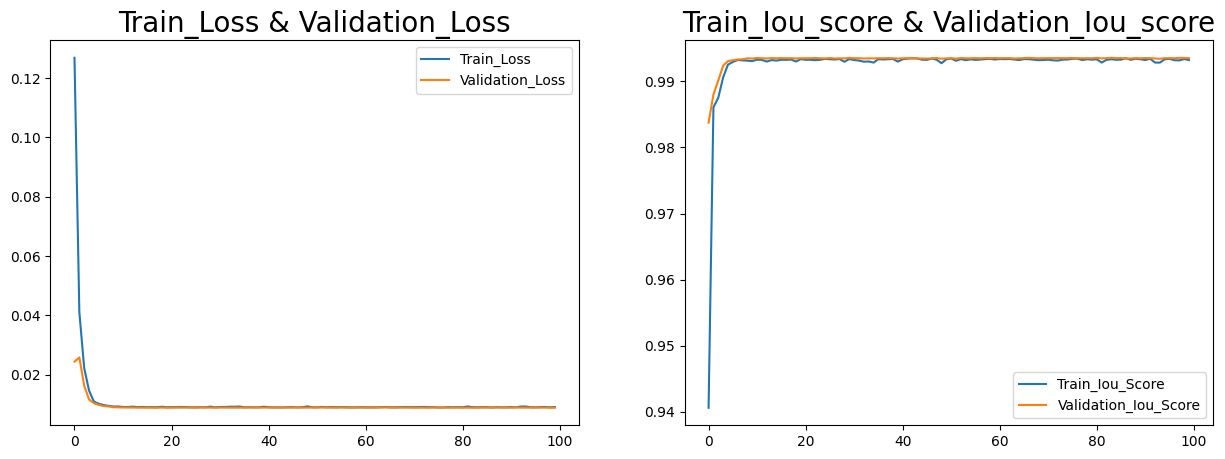

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [25]:
test_transforms = A.Compose([
    A.Resize(512, 512),
    # ToTensorV2(),
])


In [26]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img/255
        # img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset = TestDataset(test_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=4)


In [27]:
model.load_state_dict(torch.load('checkpoints/best1.pth'))
model.to(device)

def get_metrics(model, dataloader, threshold):
    IoU_score, precision, f1_score, recall, acc, dice_score = 0, 0, 0, 0, 0, 0
    batches = 0
    model.eval()
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device)  # move data to GPU
            pred = model(x)
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()

            # Calculate stats
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=threshold)

            # Calculate various metrics
            batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            batch_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
            batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()

            # Manually calculate Dice score
            dice = (2 * tp.sum()) / (2 * tp.sum() + fp.sum() + fn.sum())
            batch_dice_score = dice.item()

            # Aggregate the results
            IoU_score += batch_iou_score
            acc += batch_acc
            f1_score += batch_f1_score
            recall += batch_recall
            precision += batch_precision
            dice_score += batch_dice_score
            batches += 1

    # Compute average metrics over all batches
    IoU_score = round(IoU_score / batches, 3)
    precision = round(precision / batches, 3)
    f1_score = round(f1_score / batches, 3)
    recall = round(recall / batches, 3)
    acc = round(acc / batches, 3)
    dice_score = round(dice_score / batches, 3)

    sample = {
        'iou': IoU_score,
        'pre': precision,
        'fi': f1_score,
        're': recall,
        'acc': acc,
        'dice': dice_score
    }
    return sample

# Evaluate the model for different thresholds
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model, test_loader, threshold)
    print(f"Threshold: {threshold:.2f} \
    IoU Score: {sample['iou']:.3f} \
    Precision: {sample['pre']:.3f} \
    F1 Score: {sample['fi']:.3f} \
    Recall: {sample['re']:.3f} \
    Accuracy: {sample['acc']:.3f} \
    Dice Score: {sample['dice']:.3f}")


<ipython-input-27-fb1de435b8dc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/best1.pth'))


Threshold: 0.30     IoU Score: 0.993     Precision: 0.994     F1 Score: 0.997     Recall: 0.999     Accuracy: 0.993     Dice Score: 0.997
Threshold: 0.40     IoU Score: 0.993     Precision: 0.995     F1 Score: 0.997     Recall: 0.998     Accuracy: 0.993     Dice Score: 0.997
Threshold: 0.50     IoU Score: 0.993     Precision: 0.996     F1 Score: 0.997     Recall: 0.998     Accuracy: 0.993     Dice Score: 0.997
Threshold: 0.60     IoU Score: 0.993     Precision: 0.996     F1 Score: 0.997     Recall: 0.997     Accuracy: 0.993     Dice Score: 0.997
Threshold: 0.70     IoU Score: 0.993     Precision: 0.997     F1 Score: 0.997     Recall: 0.996     Accuracy: 0.993     Dice Score: 0.997
